In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
from nflib.coupling_flows import AffineHalfFlow, MLP_Generator, DimensionMixer
from nflib.doublerelu_flow import DoubleReluLinearFlow

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

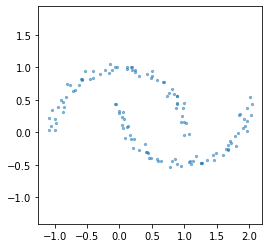

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [5]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

flows = [
#     LinearFlow(2, identity_init=False),
    *[DoubleReluLinearFlow(2, identity_init=False) for _ in range(1)],
]

model = NormalizingFlow(flows, prior)

In [6]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): DoubleReluLinearFlow()
    )
  )
)

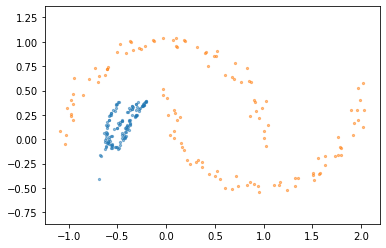

In [7]:
x = d.sample(128)
z = model.flow(x, False)
z = z.data.detach()
plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5)
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [8]:
model.flow(x, True)[1]

tensor([-5.2212,     nan, -5.2212,     nan,     nan,     nan,     nan, -5.2212,
        -5.2212,     nan, -5.2212,     nan,     nan,     nan,     nan,     nan,
        -5.2212,     nan,     nan,     nan, -5.2212, -5.2212,     nan,     nan,
        -5.2212,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan, -5.2212,     nan, -5.2212, -5.2212,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan, -5.2212,
        -5.2212,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan, -5.2212, -5.2212,     nan,     nan,     nan,     nan, -5.2212,
            nan, -5.2212, -5.2212,     nan, -5.2212,     nan,     nan,     nan,
            nan,     nan, -5.2212,     nan, -5.2212,     nan, -5.2212,     nan,
        -5.2212,     nan,     nan,     nan,     nan,     nan, -5.2212,     nan,
            nan,     nan,     nan,     n

In [9]:
model.flow.flows[0].weight.data

tensor([[0.0193, 0.0828],
        [0.2811, 0.4790],
        [0.1769, 0.2822],
        [0.2084, 0.1766]])

In [44]:
torch.det(torch.randn(4,4).abs())

tensor(0.2701)

In [10]:
adasd

NameError: name 'adasd' is not defined

In [ ]:
# model.flow.flows[0].bias

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
model.train()
for k in range(1000*1+1):
    x = d.sample(128)
    
    z, logDetJ, prior_logP = model(x, True)
    loss = -torch.mean(prior_logP + logDetJ) # NLL

    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(k, loss.item())

In [ ]:
model.eval()

x = d.sample(128)
z, logDetJ, prior_logP = model(x, True)

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample((128,))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

In [ ]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.inverse(xy, True, intermediate=True)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)